# Makemore part: 3

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read all the words 
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [7]:
len(words)

32033

In [8]:
# Build the volcabulary of the characters and mapping to/from integers 
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)
vocab_size = len(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [9]:
# Build the dataset
# Training split, dev/validation split, test split 
# 80%, 10%, 10%
# Training set: Used to optimize the parameters of the model
# Dev/ validation set: Used to development of all the hyperparameters of the model like size of the hidden layer, size of the embedding etc.
# test set: evaluate the performance of the model. You should test on test set few times otherwise you might end up overfitting to test set as well. 
block_size = 3 # context length: how many characters do we take to predict the next one?
def build_dataset(words):
    
    X, Y = [], []

    for w in words:
    #     print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
    #         print(''.join(itos[i] for i in context),'------>',itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [10]:
# MLP revisited 
n_embd = 10 # Dimensionality of the character embedding vectors 
n_hidden = 200 # The number of neurons in the hidden layer 


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd * block_size,n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden,vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

print("Total parameters:", sum(p.nelement() for p in parameters)) # Number of parameters in total
for p in parameters:
    p.requires_grad = True

Total parameters: 11897


In [11]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Creating a mini batch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    # Forward pass
    emb = C[Xtr[ix]] # (32,3,2) # Embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -0.1 * p.grad
    # Track status
    if i % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    


      0/ 200000:26.5404
  10000/ 200000:2.8081
  20000/ 200000:2.5536
  30000/ 200000:2.2321
  40000/ 200000:2.3702
  50000/ 200000:2.6762
  60000/ 200000:2.3352
  70000/ 200000:2.3170
  80000/ 200000:2.1569
  90000/ 200000:2.0086
 100000/ 200000:2.3446
 110000/ 200000:2.6480
 120000/ 200000:2.3732
 130000/ 200000:2.4724
 140000/ 200000:2.3639
 150000/ 200000:2.4341
 160000/ 200000:2.2881
 170000/ 200000:2.3129
 180000/ 200000:2.6699
 190000/ 200000:2.0227


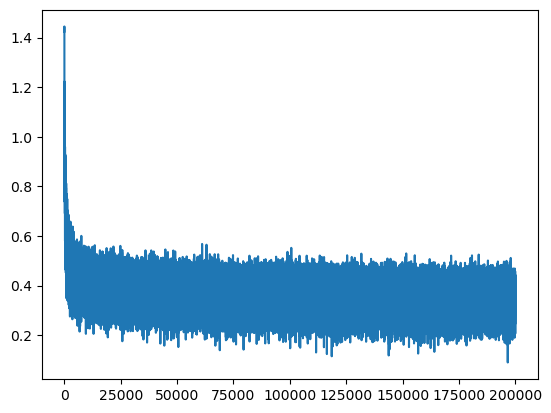

In [12]:
plt.plot(lossi)

In [13]:
@torch.no_grad() # This decorator disables gradient tracking it almost like all the tensors created in the function has requires_grad = falls. 
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': {Xdev, Ydev},
        'test': {Xte, Yte},
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.2444818019866943
val 2.3008430004119873


In [14]:
# Sample from the model 
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # Initialize with all ...
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))
        
        
        

carmah.
quielleigh.
mir.
jerty.
hucheski.
rahnee.
den.
rhe.
kaeli.
jermari.
chriir.
jaleigh.
ham.
jore.
quinton.
lilea.
jamiliorterrisharisika.
jureighayley.
emiia.
gian.


## What is wrong here?
- At the initialization of this network, the loss is too high (around 26). It shows the network is poorly configured at the initialization. 
- With training of neural nets you have a rough idea of what loss to expect at initialization. 
- For this particular case, we know that at the start all the 27 characters are equally likely to come next for any training example. So we would expect uniform probability distribution in the beginning. So the probability of any character should be 1/27 in our example. In the following cell what loss we should expect at the initialization is calculated. 


In [15]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

### Fixing initialization:
- With our current initialization, the neural net is creating probability distribution that is all messed up. Some characters are assigned very high probability whereas some are assigned very low probability. So the network is very confidently wrong. Thats what makes it record very high loss. 
- In the following cells, we are rectifying this issue. The current values of logits are very high. We are trying make them come close to zero.
- The first step is to make b2 zero as that is adding in logits calculation. 
- Second is to scale down w2. 

In [16]:
n_embd = 10 # Dimensionality of the character embedding vectors 
n_hidden = 200 # The number of neurons in the hidden layer 


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd * block_size,n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print("Total parameters:", sum(p.nelement() for p in parameters)) # Number of parameters in total
for p in parameters:
    p.requires_grad = True

Total parameters: 11897


In [18]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Creating a mini batch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    # Forward pass
    emb = C[Xtr[ix]] # (32,3,2) # Embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -0.1 * p.grad
    # Track status
    if i % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    


      0/ 200000:3.2459
  10000/ 200000:2.3544
  20000/ 200000:2.0843
  30000/ 200000:2.3805
  40000/ 200000:2.5993
  50000/ 200000:2.1307
  60000/ 200000:2.3376
  70000/ 200000:1.8359
  80000/ 200000:2.1580
  90000/ 200000:2.2627
 100000/ 200000:2.2407
 110000/ 200000:1.9775
 120000/ 200000:2.3104
 130000/ 200000:2.2975
 140000/ 200000:2.2196
 150000/ 200000:2.4413
 160000/ 200000:2.1828
 170000/ 200000:2.3385
 180000/ 200000:2.1838
 190000/ 200000:1.8202


#### Note:
- We will now not be getting the hockey shape graph. This it true for any neural network we train. 

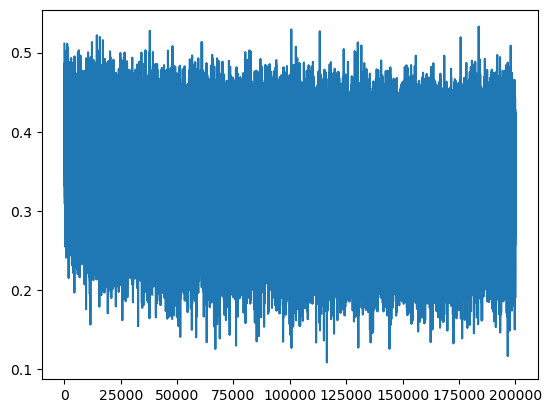

In [19]:
plt.plot(lossi)

In [22]:
@torch.no_grad() # This decorator disables gradient tracking it almost like all the tensors created in the function has requires_grad = falls. 
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': {Xdev, Ydev},
        'test': {Xte, Yte},
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.1705994606018066
val 2.238483428955078


### Note
- As we can see, we are getting slightly better results than the previous iteration because we are spending more time actually training the model rather than speding training iterations on squashing the weights initially. 

### Problem with h:
- Now as we resolved the initialization problem, there are still some issues with the value of h. 
- Many elements of h are 1 or -1. 
- tanh is a squashing function, meaning it will squash the input values between 1 and -1. 
- See the histogram below. 
- This will create a problem during back propogation. If the value is 1 or -1, we are killing the gradient by making it 0 (Check the equation of backward pass for the tanh layer). So we are effectively making the backpropogation through this tanh layer. Intutively as well the value of slope near the end of tanh is almost zero. 
- To futher assess the problem. We are also plotting the absolute values of h as a figure to show that how many times it is greater than 0.99. White parts shows whenever the condition is true. 
- In the figure, if any one column is entirely white then that corresponds to a dead neuron out of the 200 neurons. These neurons will never learn as the gradient never passes through them.
- This is not just true for tanh but true for a lot of other non-linearities. 
- This dead neuron can happen during the intialization stage when the weights and biases are such that they are not in the learning range and the neurons are dead.
- But this can also happen during the learning stage (optimization stage) as well. When the gradient is so high (maybe due to very high learning rate) that it will knock that neuron out of the data manifold, and from then no example will ever activate the neuron. They will like dead brain cells (permanent brain damage).  
- Some non linearities like leaky relu doesnt suffer this issue. 

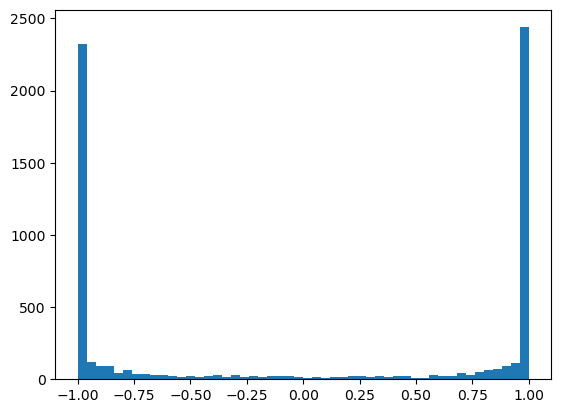

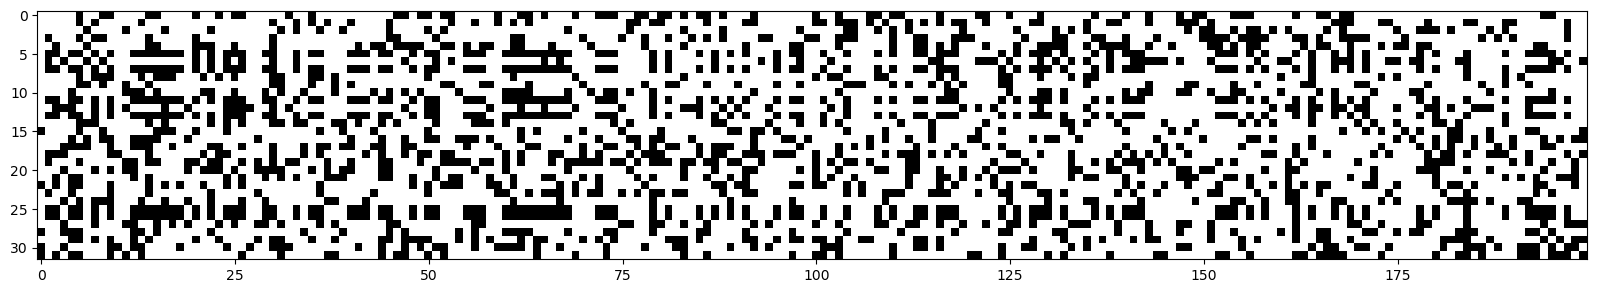

In [24]:
plt.hist(h.view(-1).tolist(), 50)
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

### Fixing the issue with tanh
- We will use the similar approach that we used to resolve the issue with initialization. 
- We will scale down the effect of W1 and b1 to get smaller values for hpreact 

In [30]:
# Fixing the issue with tanh
n_embd = 10 # Dimensionality of the character embedding vectors 
n_hidden = 200 # The number of neurons in the hidden layer 


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd * block_size,n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print("Total parameters:", sum(p.nelement() for p in parameters)) # Number of parameters in total
for p in parameters:
    p.requires_grad = True

Total parameters: 11897


In [31]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Creating a mini batch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    # Forward pass
    emb = C[Xtr[ix]] # (32,3,2) # Embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -0.1 * p.grad
    # Track status
    if i % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    break
    


      0/ 200000:3.3091


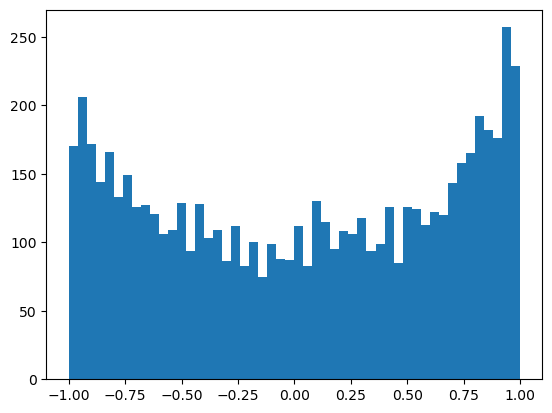

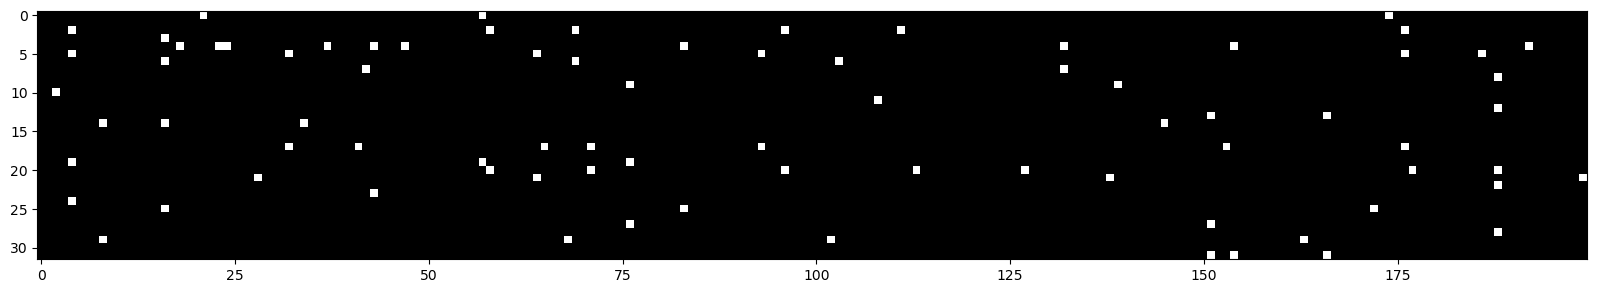

In [32]:
plt.hist(h.view(-1).tolist(), 50)
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

- This seems to be a nice distribution. 
- Now training the full model

In [33]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Creating a mini batch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    # Forward pass
    emb = C[Xtr[ix]] # (32,3,2) # Embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -0.1 * p.grad
    # Track status
    if i % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    


      0/ 200000:3.2663
  10000/ 200000:2.2931
  20000/ 200000:2.1187
  30000/ 200000:2.3928
  40000/ 200000:2.5118
  50000/ 200000:2.1796
  60000/ 200000:2.1923
  70000/ 200000:1.9117
  80000/ 200000:2.1906
  90000/ 200000:2.1909
 100000/ 200000:2.2332
 110000/ 200000:1.9322
 120000/ 200000:2.2691
 130000/ 200000:2.3383
 140000/ 200000:2.0510
 150000/ 200000:2.3847
 160000/ 200000:1.9547
 170000/ 200000:2.3453
 180000/ 200000:2.3012
 190000/ 200000:1.7317


In [34]:
split_loss('train')
split_loss('val')

train 2.1032280921936035
val 2.1764559745788574


### Notes:
- The results are better than what we obtain last time by just fixing the initialization. 
- We have been working with one layer MLP neural network so the optimization problem is easy and quite forgiving. This is not the case in general though. 
- With deeper networks the things can get complicated.
- We need a structured way of intializing and coming up with the multipliers for weights and biases. 
- Lets do an experiment. Here in the following cell, we are multiplying two gaussians and finding the mean and standard deviation of the resulting gaussian. 

tensor(-0.0044) tensor(1.0009)
tensor(-0.0003) tensor(3.1903)


(array([1.37633036e-05, 0.00000000e+00, 0.00000000e+00, 2.06449553e-05,
        2.06449553e-05, 8.25798214e-05, 1.23869732e-04, 1.99567902e-04,
        5.09242232e-04, 8.46443169e-04, 1.21117071e-03, 2.27094509e-03,
        3.44770754e-03, 5.74617924e-03, 8.91173906e-03, 1.35637357e-02,
        2.01013049e-02, 2.91644402e-02, 4.08426033e-02, 5.59684739e-02,
        7.33102364e-02, 9.45607771e-02, 1.13051775e-01, 1.29375053e-01,
        1.38864851e-01, 1.34281671e-01, 1.20188048e-01, 1.01022648e-01,
        8.09351066e-02, 6.19968009e-02, 4.65612560e-02, 3.25639762e-02,
        2.31154683e-02, 1.55938229e-02, 1.03844125e-02, 6.68208388e-03,
        4.28726906e-03, 2.60126437e-03, 1.61030652e-03, 8.05153258e-04,
        5.64295446e-04, 4.33544062e-04, 2.33976161e-04, 1.16988080e-04,
        5.50532142e-05, 2.06449553e-05, 2.06449553e-05, 2.06449553e-05,
        2.06449553e-05, 6.88165178e-06]),
 array([-17.93566132, -17.20909157, -16.48252182, -15.75595207,
        -15.02938232, -14.3028

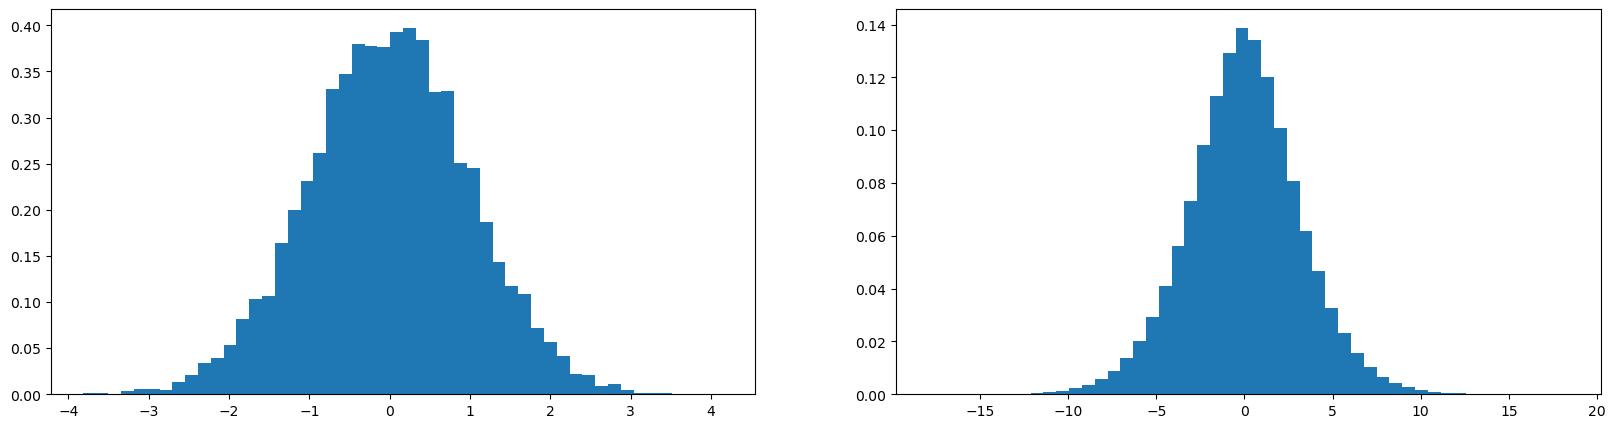

In [35]:
x = torch.randn(1000,10)
w = torch.randn(10,200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

### Note:
- We can see that the standard deviation increases after multiplication. 
- Lets multiply w by a small number and check the resulting standard deviation.

tensor(-0.0054) tensor(0.9998)
tensor(-0.0001) tensor(0.6410)


(array([1.05693171e-04, 1.76155286e-04, 1.05693171e-04, 2.11386343e-04,
        3.87541629e-04, 6.69390086e-04, 9.86469600e-04, 1.65585969e-03,
        3.38218149e-03, 4.89711694e-03, 8.80776429e-03, 1.49731993e-02,
        2.29001871e-02, 3.41741254e-02, 5.58059945e-02, 8.38146850e-02,
        1.21124374e-01, 1.77106524e-01, 2.48378953e-01, 3.26169127e-01,
        4.14211539e-01, 5.14549590e-01, 5.87548340e-01, 6.46419437e-01,
        6.65021435e-01, 6.40782468e-01, 5.77789337e-01, 4.88513838e-01,
        3.97054014e-01, 3.05382803e-01, 2.23717213e-01, 1.58293140e-01,
        1.12668921e-01, 7.33510610e-02, 4.92177868e-02, 3.15670272e-02,
        2.19489486e-02, 1.30354911e-02, 7.36329095e-03, 4.89711694e-03,
        2.92417774e-03, 1.69109074e-03, 1.05693171e-03, 6.34159029e-04,
        3.52310572e-04, 2.46617400e-04, 3.52310572e-05, 7.04621143e-05,
        0.00000000e+00, 3.52310572e-05]),
 array([-3.45943332, -3.31751308, -3.17559284, -3.0336726 , -2.89175237,
        -2.74983213, 

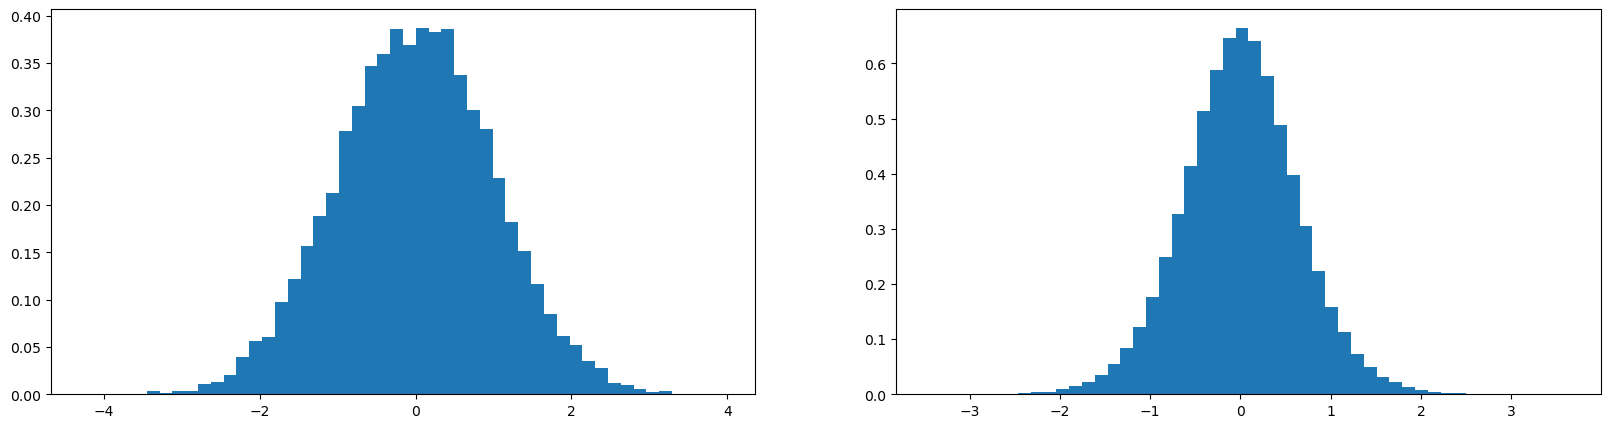

In [36]:
x = torch.randn(1000,10)
w = torch.randn(10,200) * 0.2
y = x @ w
print(x.mean(), x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

## Note:
- Now what do we multiply w with such that standard deviation remains 1? 
- The correct answer is to divide w by the square root of fan in (number of input elements). 

tensor(0.0133) tensor(0.9994)
tensor(-0.0021) tensor(0.9900)


(array([6.53221380e-05, 0.00000000e+00, 2.17740460e-05, 6.53221380e-05,
        1.95966414e-04, 4.13706874e-04, 2.83062598e-04, 6.53221380e-04,
        1.19757253e-03, 2.17740460e-03, 3.57094355e-03, 6.57576190e-03,
        8.42655581e-03, 1.47845772e-02, 2.31240369e-02, 3.59054019e-02,
        5.53060769e-02, 8.30679855e-02, 1.12593592e-01, 1.64241629e-01,
        2.20658182e-01, 2.85305325e-01, 3.54285503e-01, 4.08611747e-01,
        4.39443797e-01, 4.35502694e-01, 3.97615854e-01, 3.40415435e-01,
        2.75267490e-01, 2.08900197e-01, 1.53223962e-01, 1.10220221e-01,
        7.40753045e-02, 4.94706325e-02, 3.37497713e-02, 1.97926078e-02,
        1.36523269e-02, 8.18704130e-03, 5.22577104e-03, 3.04836644e-03,
        2.37337102e-03, 1.28466871e-03, 6.53221380e-04, 4.35480920e-04,
        2.61288552e-04, 3.04836644e-04, 6.53221380e-05, 2.17740460e-05,
        4.35480920e-05, 4.35480920e-05]),
 array([-5.7203207 , -5.49068952, -5.26105833, -5.03142715, -4.80179596,
        -4.57216477, 

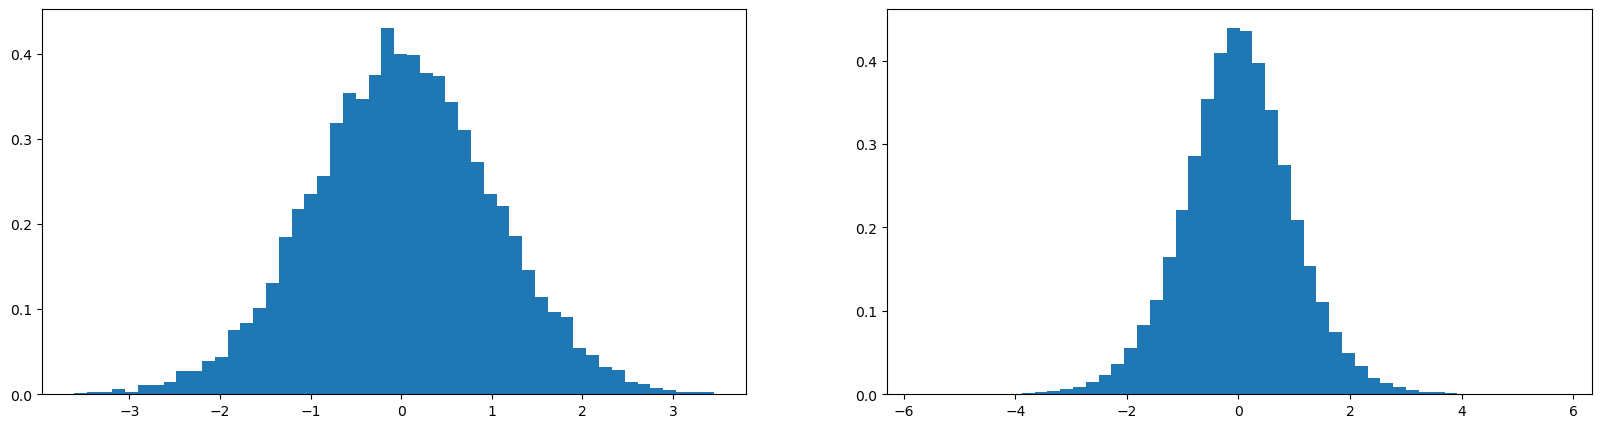

In [38]:
x = torch.randn(1000,10)
w = torch.randn(10,200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

## Note:
- You should Kaiming initialization (there is a paper). It is also implemented in Pytorch.
- This is the most common way of initializing the neuran networks now. Zero mean and unit standard deviation. 
- About the time this Kaiming paper came out, you had to be really careful the activations and the gradients, the gains, the nonlinearity. Everything was very fragile and finicky if the neural net was very deep. But there are many modern, that made everything very stable and well behaved and it has become less important to intialize these networks exactly right. These modern developments are residual connections, the use of various normalization layers like batch normalization, layer normalization, also much better optimizers like RMS Prop, ADAM. 
- Using Kaiming initialization in our example
- Kaiming normalization can be used for both activations and gradients. However, the paper shows that it doesnt affect the results too much by applying it to the gradients so by default it is applied to the activations. 


In [40]:
# Fixing the issue with tanh
n_embd = 10 # Dimensionality of the character embedding vectors 
n_hidden = 200 # The number of neurons in the hidden layer 


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd * block_size,n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print("Total parameters:", sum(p.nelement() for p in parameters)) # Number of parameters in total
for p in parameters:
    p.requires_grad = True

Total parameters: 11897


In [41]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Creating a mini batch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    # Forward pass
    emb = C[Xtr[ix]] # (32,3,2) # Embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -0.1 * p.grad
    # Track status
    if i % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0/ 200000:3.3129
  10000/ 200000:2.4228
  20000/ 200000:2.3509
  30000/ 200000:2.0158
  40000/ 200000:2.0766
  50000/ 200000:2.3837
  60000/ 200000:2.2648
  70000/ 200000:2.0855
  80000/ 200000:1.9400
  90000/ 200000:2.0193
 100000/ 200000:2.4169
 110000/ 200000:2.2877
 120000/ 200000:2.2102
 130000/ 200000:2.2873
 140000/ 200000:2.0506
 150000/ 200000:2.3827
 160000/ 200000:2.1313
 170000/ 200000:2.0129
 180000/ 200000:2.4203
 190000/ 200000:1.8138


In [42]:
split_loss('train')
split_loss('val')

train 2.1076157093048096
val 2.1758856773376465


## Batch Normalization
- The idea of batch normalization is to make the hidden states gaussian with zero mean and unit standard deviation at initialization. This operation is completely differentiable. 
- One point to note is that we want these hiddle state to be gaussian with zero mean and unit standard deviation only at initalization. During the training, we want them to move around as they are adjusted by the gradients. That is done in batch normalization using bngain and bnbias values. The values of bngain and bnbias change during backpropogation. 

In [59]:
# Batch Normalization
n_embd = 10 # Dimensionality of the character embedding vectors 
n_hidden = 200 # The number of neurons in the hidden layer 


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd * block_size,n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0


bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print("Total parameters:", sum(p.nelement() for p in parameters)) # Number of parameters in total
for p in parameters:
    p.requires_grad = True

Total parameters: 12297


In [61]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Creating a mini batch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    # Forward pass
    emb = C[Xb] # (32,3,2) # Embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 + b1 #b1 Not needed because of batch normalization.
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    # Track status
    if i % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    

      0/ 200000:3.3100
  10000/ 200000:2.3046
  20000/ 200000:2.1077
  30000/ 200000:2.3259
  40000/ 200000:2.5699
  50000/ 200000:2.3077
  60000/ 200000:2.2975
  70000/ 200000:1.8717
  80000/ 200000:2.1813
  90000/ 200000:2.2421
 100000/ 200000:2.3890
 110000/ 200000:1.8752
 120000/ 200000:2.3898
 130000/ 200000:2.2642
 140000/ 200000:1.9766
 150000/ 200000:2.3361
 160000/ 200000:2.1018
 170000/ 200000:2.1136
 180000/ 200000:2.2504
 190000/ 200000:1.7380


### Note:
- We also need to do batch normalization during the test time. 

### Note:
- Batch normalization is easy to implement in very deep neural nets compared to the previous approach. Its easy to sprinkle batch normalization layers through out the neural network.
- The effectiveness of Batchnormalization is difficult to observe in this example as the network is very small. 
- Batch normalization provides great stability to training process. 
- But stability comes at a cost, as we are doing batch normalization and finding meaning and standard deviation of the batch of the examples in a hidden state of a single example we are kind of mathematically coupling these batch of examples. So the hidden states or the logits are not only the function of a single example but a function of the batch of the examples. This seems to be a bug but it turns out to be good in training as side effect. It acts like a regularizer. It is adding entropy in a particular example and making harder for neural nets to overfit. 
- This coupling also affects the inference stage. As we are using batch normalized h values are coupled with all the examples in the batches. To solve this issue, we will have a step after training, that calculates the batchnorm mean and standard deviation a single time over the training set. And we use those values to calculate h. Refer the following cells. 

In [62]:
# Calibrate the batch norm at the end of training 

with torch.no_grad():
    # Pass the training set through 
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [63]:
@torch.no_grad() # This decorator disables gradient tracking it almost like all the tensors created in the function has requires_grad = falls. 
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': {Xdev, Ydev},
        'test': {Xte, Yte},
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.0656299591064453
val 2.1104588508605957


### Note:
- The same mean and standard deviations can be calculated in running manner. 


In [64]:
@torch.no_grad() # This decorator disables gradient tracking it almost like all the tensors created in the function has requires_grad = falls. 
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': {Xdev, Ydev},
        'test': {Xte, Yte},
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.0654807090759277
val 2.1108672618865967


## Note:
- When we are using batch normalization then the bias term becomes useless as we are calulating mean and then subtracting it. If you check b1.grad that would be zero.

## Additional notes on batch normalization
- Batch normalization can be sprinkled across the neural network but generally we add it after the layers that have multiplications like linear layer or convolutional layers. 